In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
img  = cv2.imread("test_images/virat_kohli1.png")
img.shape

(374, 374, 3)

# wavelet trandformation

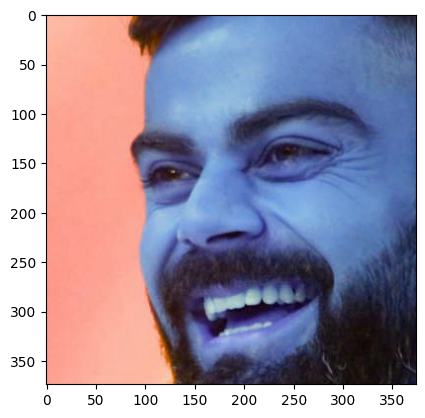

In [3]:
plt.imshow(img)

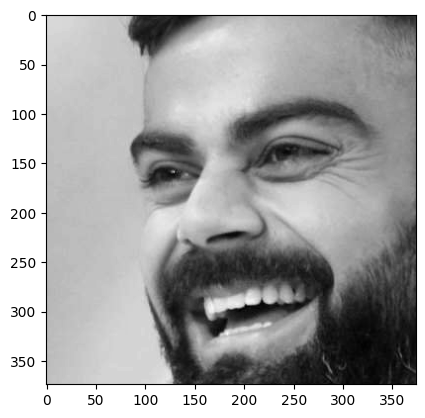

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

**Doing Wavelet transform**

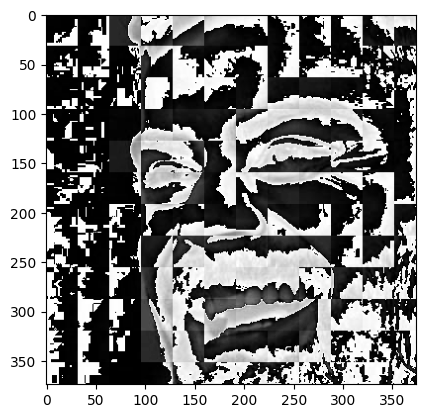

In [5]:
import pywt
def w2d(img, mode='haar',level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray =  np.float32(imArray)
    #normalisation
    imArray /= 255
    coeff = pywt.wavedec2(imArray, mode, level=level)
    
    #Process Coefficients
    coeffs_H = list(coeff)
    coeffs_H[0] *=0;
    
    #reconstruction - inverse wavelet transformation
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *=255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

img_har = w2d(img,'db1',5)
plt.imshow(img_har, cmap='gray')


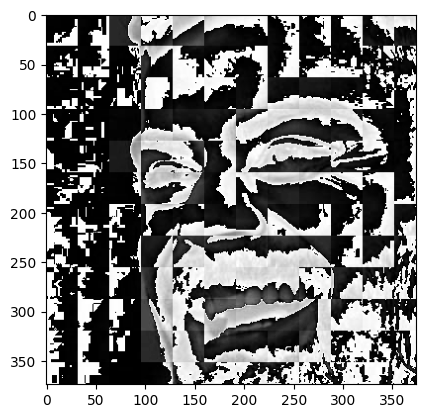

In [6]:
img_har = w2d(img,level=5)
plt.imshow(img_har, cmap='gray')

# data collection from files

In [7]:
import os
cropped_folder = "./images/cropped"
celeb_folders = os.listdir(cropped_folder)
celeb_faces = {}
for celeb in celeb_folders:
    celeb_folder = cropped_folder+"/"+celeb
    print(celeb_folder)
    celeb_faces[celeb] = os.listdir(celeb_folder)
celeb_faces

./images/cropped/lionel_messi
./images/cropped/roger_federer
./images/cropped/ronaldo
./images/cropped/virat_kohli


{'lionel_messi': ['lionel_messi1.png',
  'lionel_messi10.png',
  'lionel_messi11.png',
  'lionel_messi13.png',
  'lionel_messi14.png',
  'lionel_messi15.png',
  'lionel_messi16.png',
  'lionel_messi17.png',
  'lionel_messi18.png',
  'lionel_messi19.png',
  'lionel_messi2.png',
  'lionel_messi20.png',
  'lionel_messi21.png',
  'lionel_messi22.png',
  'lionel_messi23.png',
  'lionel_messi24.png',
  'lionel_messi25.png',
  'lionel_messi26.png',
  'lionel_messi28.png',
  'lionel_messi3.png',
  'lionel_messi31.png',
  'lionel_messi32.png',
  'lionel_messi33.png',
  'lionel_messi34.png',
  'lionel_messi35.png',
  'lionel_messi36.png',
  'lionel_messi4.png',
  'lionel_messi6.png',
  'lionel_messi7.png',
  'lionel_messi8.png',
  'lionel_messi9.png'],
 'roger_federer': ['roger_federer1.png',
  'roger_federer10.png',
  'roger_federer11.png',
  'roger_federer12.png',
  'roger_federer13.png',
  'roger_federer14.png',
  'roger_federer15.png',
  'roger_federer17.png',
  'roger_federer18.png',
  'rog

In [8]:
class_dict = {}
count=0
for celeb in celeb_faces.keys():
    class_dict[celeb] = count
    count+=1
class_dict

{'lionel_messi': 0, 'roger_federer': 1, 'ronaldo': 2, 'virat_kohli': 3}

In [9]:
X, y = [],[]
for celeb_name, files in celeb_faces.items():
    for file in files:
        img = cv2.imread(cropped_folder+"/"+celeb_name+"/"+file)
        scaled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_har_img = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1), scalled_har_img.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celeb_name])
print(len(X[0]), 32*32*3+32*32)

4096 4096


In [10]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [11]:
y[0]

0

In [12]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(120, 4096)

# training the model

In [13]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=0)
pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8333333333333334

In [15]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      0.75      0.86         4
           3       0.80      1.00      0.89         4

    accuracy                           0.83        12
   macro avg       0.85      0.83      0.83        12
weighted avg       0.85      0.83      0.83        12



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# using GridSearchCV

In [18]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [19]:
scores = []
best_estimator = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        "model":algo,
        "best score":clf.best_score_,
        "best params":clf.best_params_
    })
    best_estimator[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns = ["model","best score", "best params"])
df


,model,best score,best params
0,svm,0.844156,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.658009,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.824675,{'logisticregression__C': 1}


In [20]:
best_estimator

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [21]:
best_estimator['svm'].score(X_test,y_test)

0.9166666666666666

In [22]:
best_estimator['random_forest'].score(X_test,y_test)

0.5833333333333334

In [23]:
best_estimator["logistic_regression"].score(X_test, y_test)

0.9166666666666666

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, best_estimator['svm'].predict(X_train))
cm

array([[27,  0,  0,  0],
       [ 0, 19,  0,  0],
       [ 0,  0, 25,  0],
       [ 0,  0,  0, 37]], dtype=int64)

In [34]:
index =[]
columns = []
for i in range(4):
    index.append("Actual "+ str(i))
    columns.append("predicted "+str(i))
cm_df = pd.DataFrame(cm,index=index, columns=columns)
cm_df

,predicted 0,predicted 1,predicted 2,predicted 3
Actual 0,27,0,0,0
Actual 1,0,19,0,0
Actual 2,0,0,25,0
Actual 3,0,0,0,37


In [35]:
!pip install joblib
import joblib
joblib.dump(best_estimator['svm'], "cele_face_recog_model.pkl")


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


['cele_face_recog_model.pkl']

In [38]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))
class_dict

{'lionel_messi': 0, 'roger_federer': 1, 'ronaldo': 2, 'virat_kohli': 3}